In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [3]:
#open the netcdf file
ds = xr.open_dataset('subset_all_variables.nc')
ds

<xarray.Dataset> Size: 36MB
Dimensions:         (s_rho: 1, eta_rho: 254, xi_rho: 224, eta_u: 254,
                     xi_u: 223, eta_v: 253, xi_v: 224, ocean_time: 16)
Coordinates:
  * s_rho           (s_rho) float64 8B -0.01389
    lon_rho         (eta_rho, xi_rho) float64 455kB ...
    lat_rho         (eta_rho, xi_rho) float64 455kB ...
    lon_u           (eta_u, xi_u) float64 453kB ...
    lat_u           (eta_u, xi_u) float64 453kB ...
    lon_v           (eta_v, xi_v) float64 453kB ...
    lat_v           (eta_v, xi_v) float64 453kB ...
  * ocean_time      (ocean_time) datetime64[ns] 128B 2023-06-10 ... 2023-06-1...
Dimensions without coordinates: eta_rho, xi_rho, eta_u, xi_u, eta_v, xi_v
Data variables: (12/13)
    hc              float64 8B ...
    Cs_r            (s_rho) float64 8B ...
    h               (eta_rho, xi_rho) float64 455kB ...
    angle           (eta_rho, xi_rho) float64 455kB ...
    u_rotate        (ocean_time, s_rho, eta_rho, xi_rho) float32 4MB ...
    v_rotate        (ocean_time, s_rho, eta_rho, xi_rho) float32 4MB ...
    ...              ...
    sustr_rotate    (ocean_time, eta_rho, xi_rho) float32 4MB ...
    svstr_rotate    (ocean_time, eta_rho, xi_rho) float32 4MB ...
    sustr           (ocean_time, eta_u, xi_u) float32 4MB ...
    svstr           (ocean_time, eta_v, xi_v) float32 4MB ...
    u               (ocean_time, s_rho, eta_u, xi_u) float32 4MB ...
    v               (ocean_time, s_rho, eta_v, xi_v) float32 4MB ...
Attributes: (12/36)
    file:                       /mnt/lfs4/NOS/nosofs/Yizhen.Li/23forecast/his...
    format:                     netCDF-3 64bit offset file
    Conventions:                CF-1.4
    type:                       ROMS/TOMS history file
    title:                      Gulf of Maine physical-biological model multi...
    rst_file:                   /mnt/lfs4/NOS/nosofs/Yizhen.Li/23forecast/res...
    ...                         ...
    ana_file:                   ROMS/Functionals/ana_btflux.h, ROMS/Functiona...
    bio_file:                   ROMS/Nonlinear/Biology/red_tide.h
    CPP_options:                GOM6, ADD_FSOBC, ADD_M2OBC, ANA_BPFLUX, ANA_B...
    NCO:                        netCDF Operators version 4.7.5 (Homepage = ht...
    nco_openmp_thread_number:   1
    history_of_appended_files:  Thu Nov 14 16:57:46 2024: Appended file cell_...

In [4]:
# plot the dinoflagellate data as a function of ocean_time
ds['dinoflagellate'].head()

<xarray.DataArray 'dinoflagellate' (ocean_time: 5, s_rho: 1, eta_rho: 5,
                                    xi_rho: 5)> Size: 500B
[125 values with dtype=float32]
Coordinates:
  * s_rho       (s_rho) float64 8B -0.01389
    lon_rho     (eta_rho, xi_rho) float64 200B ...
    lat_rho     (eta_rho, xi_rho) float64 200B ...
  * ocean_time  (ocean_time) datetime64[ns] 40B 2023-06-10 ... 2023-06-12
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    long_name:  red tide dinoflagellate concentration
    units:      cell meter-3
    time:       ocean_time
    field:      dinoflagellate, scalar, series

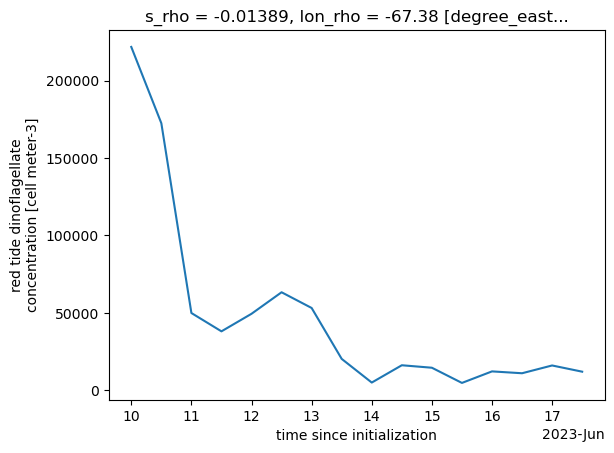

In [5]:
# plot the dinoflagellate data as a function of ocean_time at a specific location
ds['dinoflagellate'].isel(s_rho=0,eta_rho=100,xi_rho=100).plot()

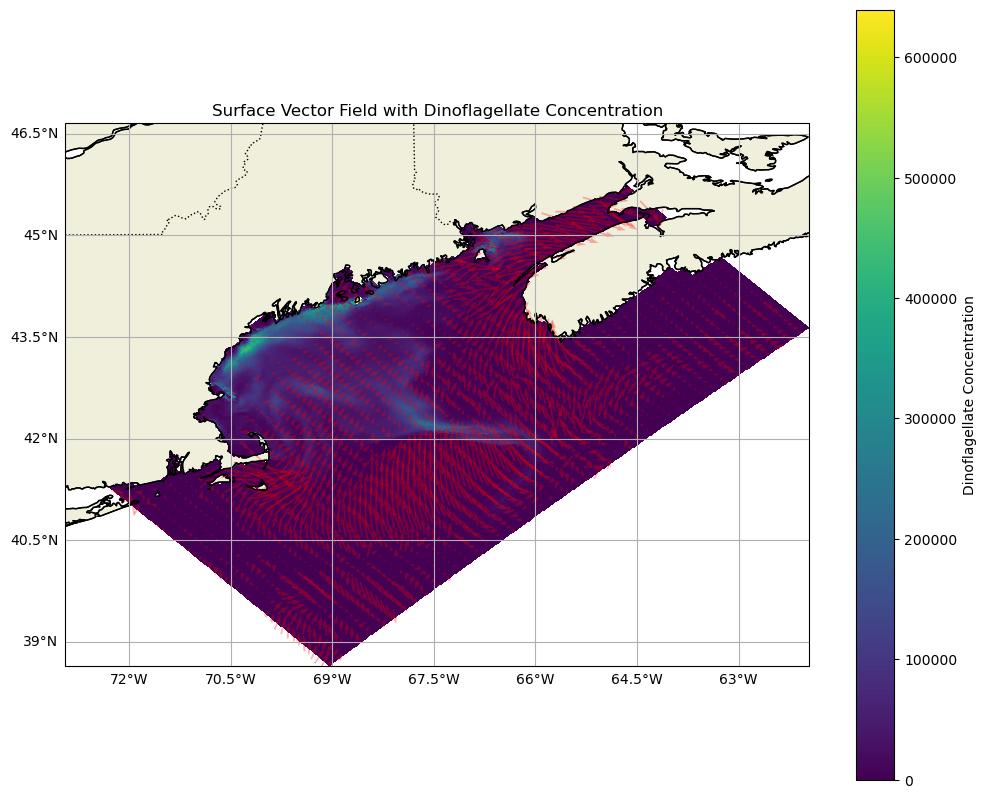

In [8]:
# Extract variables
lon_rho = ds["lon_rho"]
lat_rho = ds["lat_rho"]
u = ds["u"].isel(ocean_time=0, s_rho=-1)  # Surface level
v = ds["v"].isel(ocean_time=0, s_rho=-1)  # Surface level
dinoflagellate = ds["dinoflagellate"].isel(ocean_time=0, s_rho=-1)

# Downsample quiver data (adjust step size as needed)
step = 5  # Downsampling factor
lon_quiver = lon_rho[::step, ::step]
lat_quiver = lat_rho[::step, ::step]
u_quiver = u[::step, ::step]
v_quiver = v[::step, ::step]

# Plot
fig = plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add dinoflagellate as a colormap
mesh = ax.pcolormesh(
    lon_rho,
    lat_rho,
    dinoflagellate,
    cmap="viridis",
    shading="auto",
    transform=ccrs.PlateCarree(),
)

# Add colorbar
cbar = plt.colorbar(mesh, ax=ax, orientation="vertical", label="Dinoflagellate Concentration")

# Add downsampled quiver plot
quiver = ax.quiver(
    lon_quiver,
    lat_quiver,
    u_quiver,
    v_quiver,
    scale=30,
    pivot="middle",
    color="red",
    alpha=0.3,
    transform=ccrs.PlateCarree(),
)

# Add coastlines and geographic features
ax.coastlines(resolution="10m", linewidth=1)
ax.add_feature(cfeature.LAND, edgecolor="black")
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Gridlines and labels
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

plt.title("Surface Vector Field with Dinoflagellate Concentration")
plt.show()